<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/02-Classifica%C3%A7%C3%A3o_Regress%C3%A3o_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 16,
     'axes.labelsize': 22,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )
import sklearn
print ( sklearn.__version__ )

1.6.1


## Amostra de dados

In [2]:
x1_min = 0.
x1_max = 5.
x2_min = 0.
x2_max = 5.

def create_dataset( n_data, p0, p1 ):
    def func_sep( X ):
        return +1 if ( X[1] >= p0 + p1 * X[0] ) else 0

    X = np.c_[
        x1_min + ( x1_max - x1_min ) * np.random.rand( n_data, 1 ),
        x2_min + ( x2_max - x2_min ) * np.random.rand( n_data, 1 )
        ]

    y = np.apply_along_axis( func_sep, 1, X ).astype( np.int32 )

    return ( X, y )

In [3]:
np.random.seed( 42 )
n_data = 50
p0 = 3.0
p1 = -0.5
X_train, y_train = create_dataset( n_data, p0, p1 )
df_train = pd.DataFrame( np.c_[ X_train, y_train ], columns=( "x1", "x2", "y_label" ) ).astype( { "y_label": "int32" } )

np.random.seed( 100 )
X_test, y_test = create_dataset( n_data, p0, p1 )
df_test = pd.DataFrame( np.c_[ X_test, y_test ], columns=( "x1", "x2", "y_label" ) ).astype( { "y_label": "int32" } )

[Text(0, 0.0, ''),
 Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, '')]

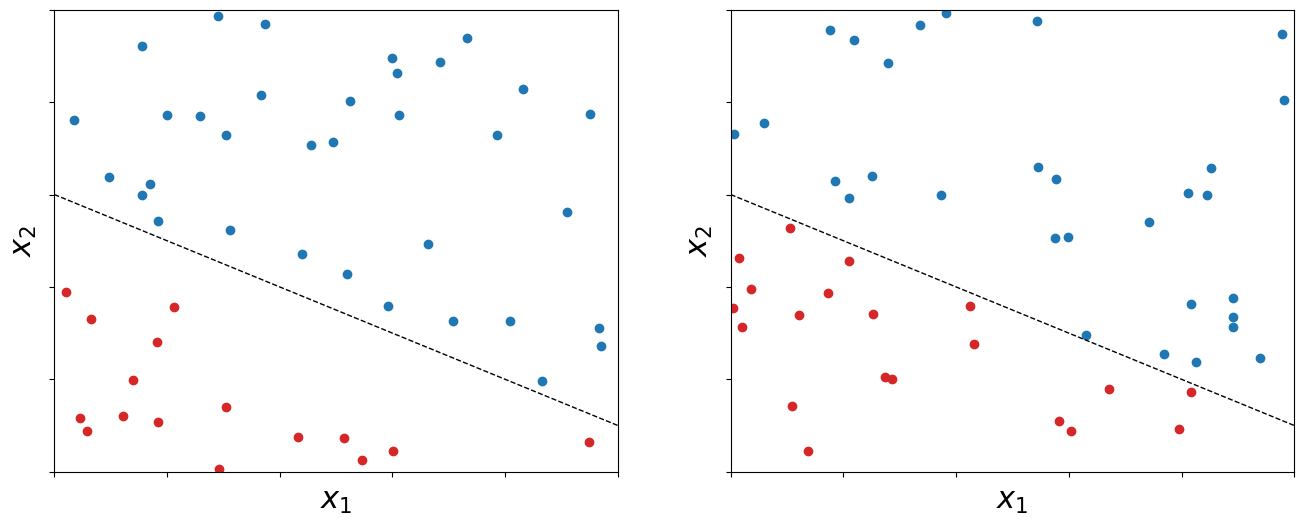

In [4]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )

msk_sig = ( df_train[ "y_label" ] == +1 )
msk_bkg = ( df_train[ "y_label" ] ==  0 )
df_train_sig = df_train[ msk_sig ]
df_train_bkg = df_train[ msk_bkg ]
axes[0].plot( df_train_sig[ "x1" ], df_train_sig[ "x2" ], 'o', color='tab:blue' )
axes[0].plot( df_train_bkg[ "x1" ], df_train_bkg[ "x2" ], 'o', color='tab:red' )
axes[0].plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashed', linewidth=1, color='black' )

axes[0].set_xlim( x1_min, x1_max )
axes[0].set_ylim( x2_min, x2_max )
axes[0].set_xlabel( r'$x_1$' )
axes[0].set_ylabel( r'$x_2$' )
axes[0].xaxis.set_ticklabels( [] )
axes[0].yaxis.set_ticklabels( [] )

msk_sig = ( df_test[ "y_label" ] == +1 )
msk_bkg = ( df_test[ "y_label" ] ==  0 )
df_test_sig = df_test[ msk_sig ]
df_test_bkg = df_test[ msk_bkg ]
axes[1].plot( df_test_sig[ "x1" ], df_test_sig[ "x2" ], 'o', color='tab:blue' )
axes[1].plot( df_test_bkg[ "x1" ], df_test_bkg[ "x2" ], 'o', color='tab:red' )
axes[1].plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashed', linewidth=1, color='black' )

axes[1].set_xlim( x1_min, x1_max )
axes[1].set_ylim( x2_min, x2_max )
axes[1].set_xlabel( r'$x_1$' )
axes[1].set_ylabel( r'$x_2$' )
axes[1].xaxis.set_ticklabels( [] )
axes[1].yaxis.set_ticklabels( [] )

## Regressão Logística

$h( \mathbf{x}; \mathbf{w} ) = \sigma( \mathbf{w}^{T} \cdot \mathbf{x} )$

Text(0, 0.5, '$\\sigma( s )$')

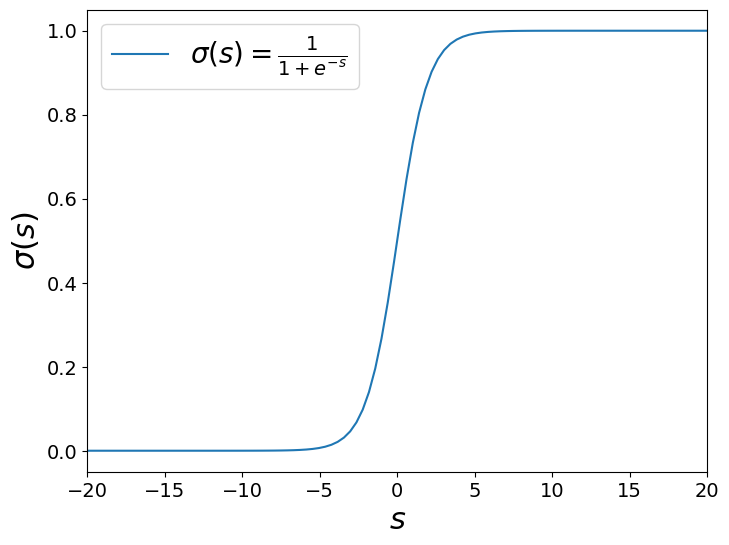

In [5]:
fig = plt.figure( figsize=(8,6) )
xplot_ = np.linspace( -20., 20., 100 )
plt.plot( xplot_, ( lambda x: 1. / ( 1. + np.exp( -x ) ) )( xplot_ ), label=r"$\sigma( s ) = \frac{1}{1 + e^{-s}}$" )
plt.legend( loc='upper left', fontsize=20 )
plt.xlim( -20., 20. )
plt.xlabel( r'$s$' )
plt.ylabel( r'$\sigma( s )$' )

$y_n = 1$ ou $y_n = 0$

$ p( \mathbf{x}_n; \mathbf{w} ) = \begin{cases} h( \mathbf{x}_n; \mathbf{w} ) , \quad y_n = 1 \\ 1 - h( \mathbf{x}_n; \mathbf{w} ) , \quad y_n = 0 \end{cases} $


### Treinamento

$ {\cal L}( \mathbf{X} | \mathbf{w} ) = \prod_{n=1}^{N} p( \mathbf{x}_n; \mathbf{w} )$

$ J( \mathbf{w} ) = -\frac{1}{N}\log {\cal L} = -\frac{1}{N} \sum_{n=1}^{N} \left[ y_n \log h( \mathbf{x}_n; \mathbf{w} ) + ( 1 - y_n ) \log \left( 1 - h( \mathbf{x}_n; \mathbf{w} ) \right) \right] $


In [6]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression()
log_reg.fit( df_train[ [ "x1", "x2" ] ], df_train[ "y_label" ] )

LogisticRegression()

In [7]:
print ( log_reg.coef_ )
print ( log_reg.intercept_ )

[[1.03158336 2.29282517]]
[-5.74570857]


In [8]:
y_predict_proba_train = log_reg.predict_proba( df_train[ [ "x1", "x2" ] ] )
df_train[ "y_predict_proba" ] = y_predict_proba_train[ :, 1] # Prob. y = 1
df_train

,x1,x2,y_label,y_predict_proba
0,1.872701,4.847923,1,0.999326
1,4.753572,3.875664,1,0.999679
2,3.659970,4.697495,1,0.999849
3,2.993292,4.474137,1,0.999500
4,0.780093,2.989500,1,0.871403
5,0.779973,4.609371,1,0.996415
6,0.290418,0.442463,0,0.011755
7,4.330881,0.979914,1,0.724866
8,3.005575,0.226136,0,0.106527
9,3.540363,1.626652,1,0.837003


Text(0, 0.5, 'Número de ocorrências')

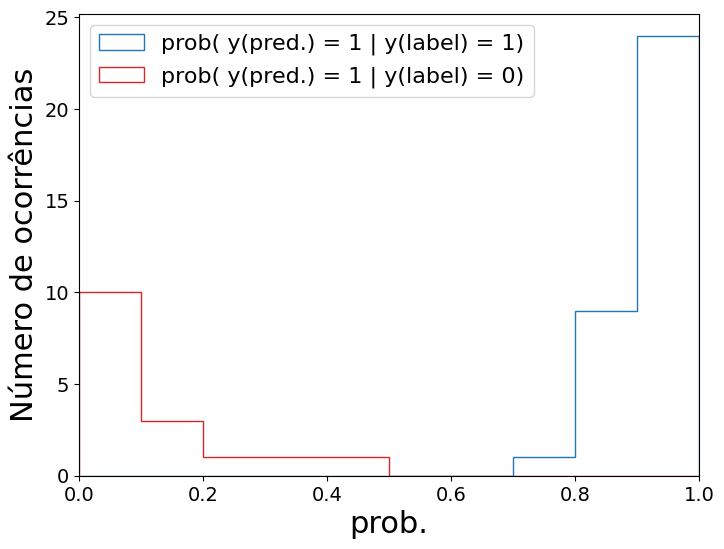

In [9]:
msk_sig = ( df_train[ "y_label" ] == +1 )
msk_bkg = ( df_train[ "y_label" ] ==  0 )

fig = plt.figure( figsize=(8,6) )
plt.hist( y_predict_proba_train[ msk_sig ][ :, 1 ], histtype='step', color="tab:blue" , label="prob( y(pred.) = 1 | y(label) = 1)", bins=10, range=(0.,1.) )
plt.hist( y_predict_proba_train[ msk_bkg ][ :, 1 ], histtype='step', color="tab:red" , label="prob( y(pred.) = 1 | y(label) = 0)", bins=10, range=(0.,1.) )
# plt.hist( y_predict_proba_train[ msk_sig ][ :, 0 ], histtype='step', color="tab:blue" , label="prob( y(pred.) = 0 | y(label) = 1)", bins=10, range=(0.,1.) )
# plt.hist( y_predict_proba_train[ msk_bkg ][ :, 0 ], histtype='step', color="tab:red" , label="prob( y(pred.) = 0 | y(label) = 0)", bins=10, range=(0.,1.) )
plt.legend( loc='upper left' )
plt.xlim( 0., 1. )
plt.xlabel( "prob." )
plt.ylabel( "Número de ocorrências" )

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[Text(0, 0.0, ''),
 Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, '')]

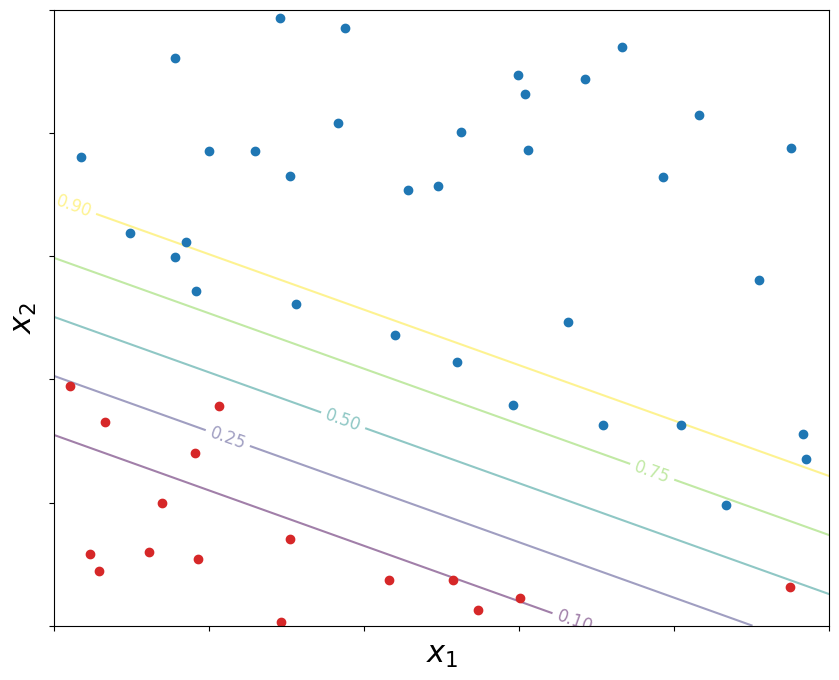

In [10]:
fig = plt.figure( figsize=(10,8) )

n_points_ = 500
data_x1_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
data_x2_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
grid_x1_, grid_x2_ = np.meshgrid( data_x1_, data_x2_ )
datascan_ = np.c_[ grid_x1_.ravel(), grid_x2_.ravel() ]
datascan_predict_ = ( log_reg.predict_proba( datascan_ )[ :, 1] ).reshape( grid_x1_.shape )

contour_ = plt.contour( grid_x1_, grid_x2_, datascan_predict_, levels = [ 0.10, 0.25, 0.50, 0.75, 0.90 ], alpha=0.50 )
plt.clabel(contour_, inline=1, fontsize=12)

msk_sig = ( df_train[ "y_label" ] == +1 )
msk_bkg = ( df_train[ "y_label" ] ==  0 )
df_train_sig = df_train[ msk_sig ]
df_train_bkg = df_train[ msk_bkg ]
plt.plot( df_train_sig[ "x1" ], df_train_sig[ "x2" ], 'o', color='tab:blue' )
plt.plot( df_train_bkg[ "x1" ], df_train_bkg[ "x2" ], 'o', color='tab:red' )
# plt.plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashdot', linewidth=1, color='tab:red' )

plt.xlim( x1_min, x1_max )
plt.ylim( x2_min, x2_max )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.gca().xaxis.set_ticklabels( [] )
plt.gca().yaxis.set_ticklabels( [] )

### Teste

Text(0, 0.5, 'Número de ocorrências')

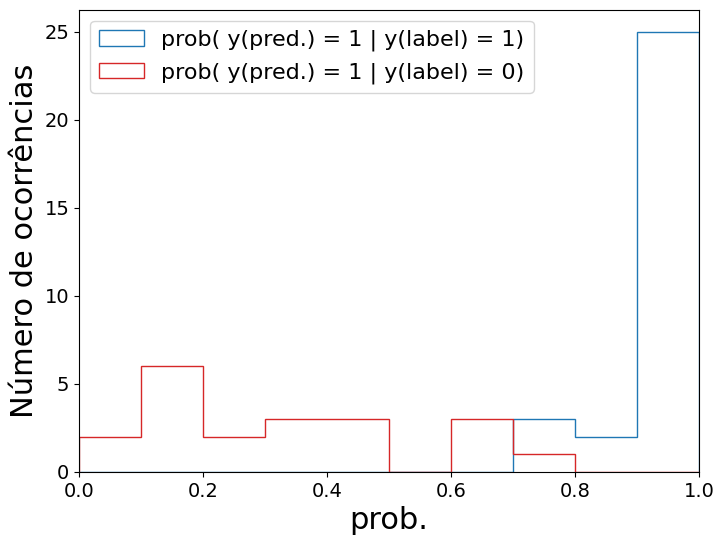

In [11]:
y_predict_proba_test = log_reg.predict_proba( df_test[ [ "x1", "x2" ] ] )
df_test[ "y_predict_proba" ] = y_predict_proba_test[ :, 1] # Prob. y = 1

msk_sig = ( df_test[ "y_label" ] == +1 )
msk_bkg = ( df_test[ "y_label" ] ==  0 )

fig = plt.figure( figsize=(8,6) )
plt.hist( y_predict_proba_test[ msk_sig ][ :, 1 ], histtype='step', color="tab:blue" , label="prob( y(pred.) = 1 | y(label) = 1)", bins=10, range=(0.,1.) )
plt.hist( y_predict_proba_test[ msk_bkg ][ :, 1 ], histtype='step', color="tab:red" , label="prob( y(pred.) = 1 | y(label) = 0)", bins=10, range=(0.,1.) )
# plt.hist( y_predict_proba_test[ msk_sig ][ :, 0 ], histtype='step', color="tab:blue" , label="prob( y(pred.) = 0 | y(label) = 1)", bins=10, range=(0.,1.) )
# plt.hist( y_predict_proba_test[ msk_bkg ][ :, 0 ], histtype='step', color="tab:red" , label="prob( y(pred.) = 0 | y(label) = 0)", bins=10, range=(0.,1.) )
plt.legend( loc='upper left' )
plt.xlim( 0., 1. )
plt.xlabel( "prob." )
plt.ylabel( "Número de ocorrências" )

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy = 0.92


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy = 0.98


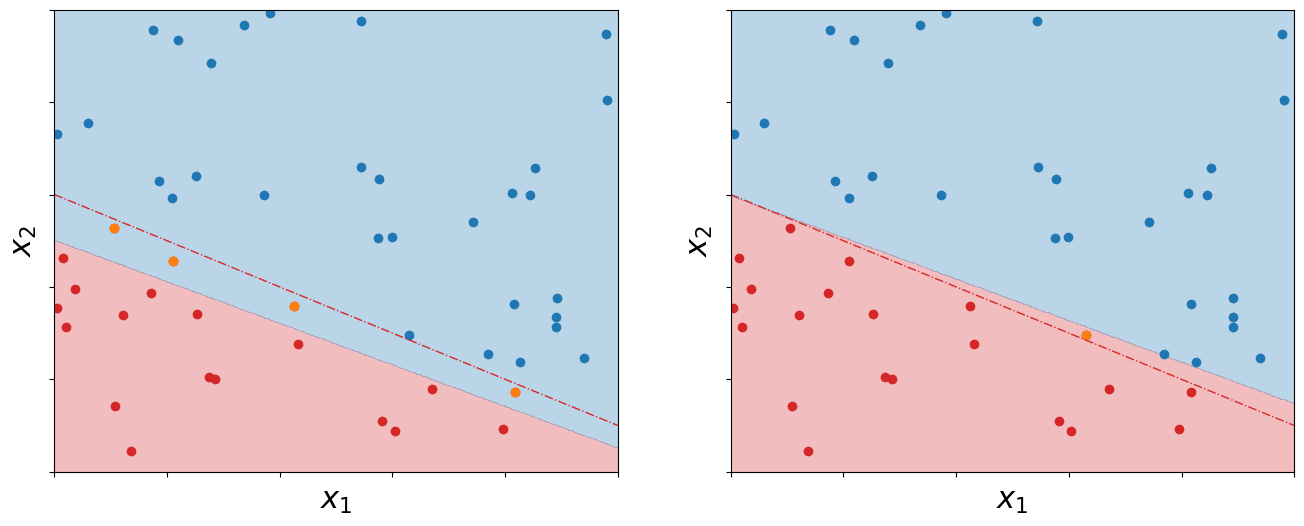

In [12]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )

prob_cut_list = [ 0.50, 0.75 ]

for idx_,prob_cut_ in enumerate( prob_cut_list ):
    n_points_ = 500
    data_x1_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
    data_x2_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
    grid_x1_, grid_x2_ = np.meshgrid( data_x1_, data_x2_ )
    datascan_ = np.c_[ grid_x1_.ravel(), grid_x2_.ravel() ]
    datascan_predict_ = ( ( log_reg.predict_proba( datascan_ )[ :, 1] >= prob_cut_ ).reshape( grid_x1_.shape ) )

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap( ['tab:red','tab:blue'] )
    axes[ idx_ ].contourf( grid_x1_, grid_x2_, datascan_predict_, cmap=custom_cmap, alpha=0.30 )

    y_predict_test_ = np.full_like( df_test[ "y_label" ], -1 )
    msk_ = ( df_test[ "y_predict_proba" ] >= prob_cut_ )
    y_predict_test_[ msk_ ]  = +1
    y_predict_test_[ ~msk_ ] =  0

    msk_sig_ = ( df_test[ "y_label" ] == +1 )
    msk_bkg_ = ( df_test[ "y_label" ] ==  0 )
    msk_error_ = ( df_test[ "y_label" ] != y_predict_test_ )
    df_test_sig_ = df_test[ msk_sig_ ]
    df_test_bkg_ = df_test[ msk_bkg_ ]
    df_test_error_ = df_test[ msk_error_ ]
    axes[ idx_ ].plot( df_test_sig_[ "x1" ], df_test_sig_[ "x2" ], 'o', color='tab:blue' )
    axes[ idx_ ].plot( df_test_bkg_[ "x1" ], df_test_bkg_[ "x2" ], 'o', color='tab:red' )
    axes[ idx_ ].plot( df_test_error_[ "x1" ], df_test_error_[ "x2" ], 'o', color='tab:orange' )
    axes[ idx_ ].plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashdot', linewidth=1, color='tab:red' )

    axes[ idx_ ].set_xlim( x1_min, x1_max )
    axes[ idx_ ].set_ylim( x2_min, x2_max )
    axes[ idx_ ].set_xlabel( r'$x_1$' )
    axes[ idx_ ].set_ylabel( r'$x_2$' )
    axes[ idx_ ].xaxis.set_ticklabels( [] )
    axes[ idx_ ].yaxis.set_ticklabels( [] )

    accuracy = np.sum( df_test[ "y_label" ] == y_predict_test_ ) / df_test.shape[0]
    print ( "Accuracy = {}".format( accuracy ) )

## Ruído

In [13]:
def add_noise( X, sigma = 0.5 ):
    return ( X + sigma * np.random.randn( *(X.shape) ) )

In [14]:
np.random.seed( 42 )
sigma = 0.5

X_train_noise = add_noise( X_train, sigma=sigma )
df_train_noise = pd.DataFrame( np.c_[ X_train_noise, y_train ], columns=( "x1", "x2", "y_label" ) ).astype( { "y_label": "int32" } )

X_test_noise = add_noise( X_test, sigma=sigma )
df_test_noise = pd.DataFrame( np.c_[ X_test_noise, y_test ], columns=( "x1", "x2", "y_label" ) ).astype( { "y_label": "int32" } )

[Text(0, 0.0, ''),
 Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, '')]

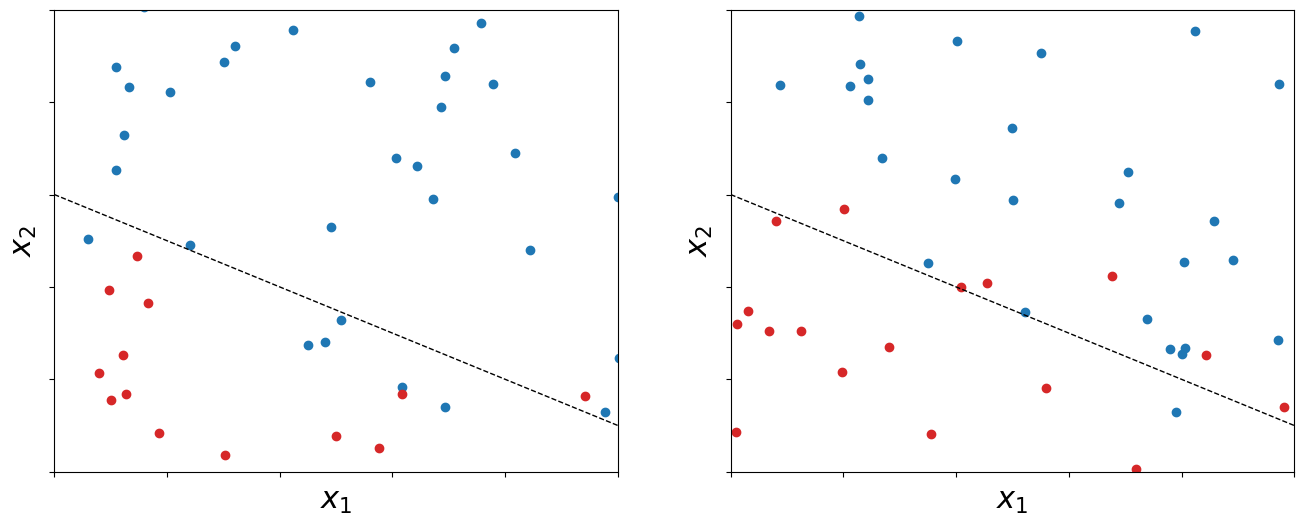

In [15]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )

df_train__ = df_train_noise

msk_sig = ( df_train__[ "y_label" ] == +1 )
msk_bkg = ( df_train__[ "y_label" ] ==  0 )
df_train_sig = df_train__[ msk_sig ]
df_train_bkg = df_train__[ msk_bkg ]
axes[0].plot( df_train_sig[ "x1" ], df_train_sig[ "x2" ], 'o', color='tab:blue' )
axes[0].plot( df_train_bkg[ "x1" ], df_train_bkg[ "x2" ], 'o', color='tab:red' )
axes[0].plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashed', linewidth=1, color='black' )

axes[0].set_xlim( x1_min, x1_max )
axes[0].set_ylim( x2_min, x2_max )
axes[0].set_xlabel( r'$x_1$' )
axes[0].set_ylabel( r'$x_2$' )
axes[0].xaxis.set_ticklabels( [] )
axes[0].yaxis.set_ticklabels( [] )

df_test__ = df_test_noise

msk_sig = ( df_test__[ "y_label" ] == +1 )
msk_bkg = ( df_test__[ "y_label" ] ==  0 )
df_test_sig = df_test__[ msk_sig ]
df_test_bkg = df_test__[ msk_bkg ]
axes[1].plot( df_test_sig[ "x1" ], df_test_sig[ "x2" ], 'o', color='tab:blue' )
axes[1].plot( df_test_bkg[ "x1" ], df_test_bkg[ "x2" ], 'o', color='tab:red' )
axes[1].plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashed', linewidth=1, color='black' )

axes[1].set_xlim( x1_min, x1_max )
axes[1].set_ylim( x2_min, x2_max )
axes[1].set_xlabel( r'$x_1$' )
axes[1].set_ylabel( r'$x_2$' )
axes[1].xaxis.set_ticklabels( [] )
axes[1].yaxis.set_ticklabels( [] )

Text(0, 0.5, 'Número de ocorrências')

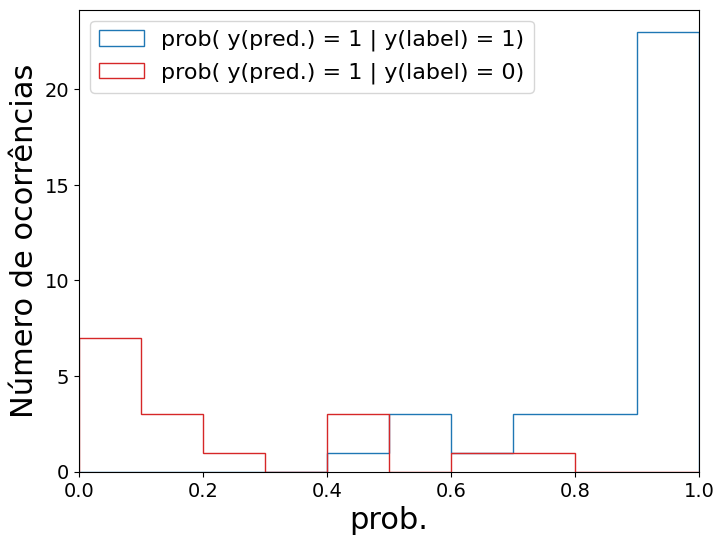

In [16]:
log_reg_noise = linear_model.LogisticRegression()
log_reg_noise.fit( df_train_noise[ [ "x1", "x2" ] ], df_train_noise[ "y_label" ] )

y_predict_proba_train_noise = log_reg_noise.predict_proba( df_train_noise[ [ "x1", "x2" ] ] )
df_train_noise[ "y_predict_proba" ] = y_predict_proba_train_noise[ :, 1] # Prob. y = 1

msk_sig = ( df_train_noise[ "y_label" ] == +1 )
msk_bkg = ( df_train_noise[ "y_label" ] ==  0 )

fig = plt.figure( figsize=(8,6) )
plt.hist( y_predict_proba_train_noise[ msk_sig ][ :, 1 ], histtype='step', color="tab:blue" , label="prob( y(pred.) = 1 | y(label) = 1)", bins=10, range=(0.,1.) )
plt.hist( y_predict_proba_train_noise[ msk_bkg ][ :, 1 ], histtype='step', color="tab:red" , label="prob( y(pred.) = 1 | y(label) = 0)", bins=10, range=(0.,1.) )
plt.legend( loc='upper left' )
plt.xlim( 0., 1. )
plt.xlabel( "prob." )
plt.ylabel( "Número de ocorrências" )

Text(0, 0.5, 'Número de ocorrências')

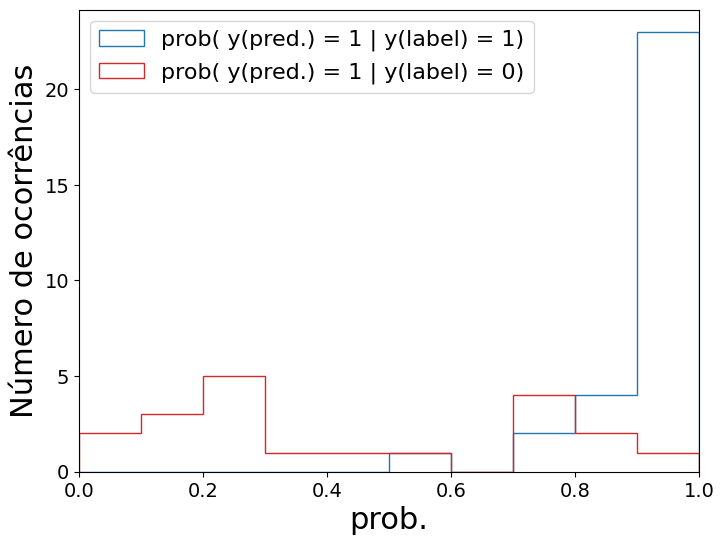

In [17]:
y_predict_proba_test_noise = log_reg_noise.predict_proba( df_test_noise[ [ "x1", "x2" ] ] )
df_test_noise[ "y_predict_proba" ] = y_predict_proba_test_noise[ :, 1] # Prob. y = 1

msk_sig = ( df_test_noise[ "y_label" ] == +1 )
msk_bkg = ( df_test_noise[ "y_label" ] ==  0 )

fig = plt.figure( figsize=(8,6) )
plt.hist( y_predict_proba_test_noise[ msk_sig ][ :, 1 ], histtype='step', color="tab:blue" , label="prob( y(pred.) = 1 | y(label) = 1)", bins=10, range=(0.,1.) )
plt.hist( y_predict_proba_test_noise[ msk_bkg ][ :, 1 ], histtype='step', color="tab:red" , label="prob( y(pred.) = 1 | y(label) = 0)", bins=10, range=(0.,1.) )
plt.legend( loc='upper left' )
plt.xlim( 0., 1. )
plt.xlabel( "prob." )
plt.ylabel( "Número de ocorrências" )

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy = 0.84


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy = 0.86


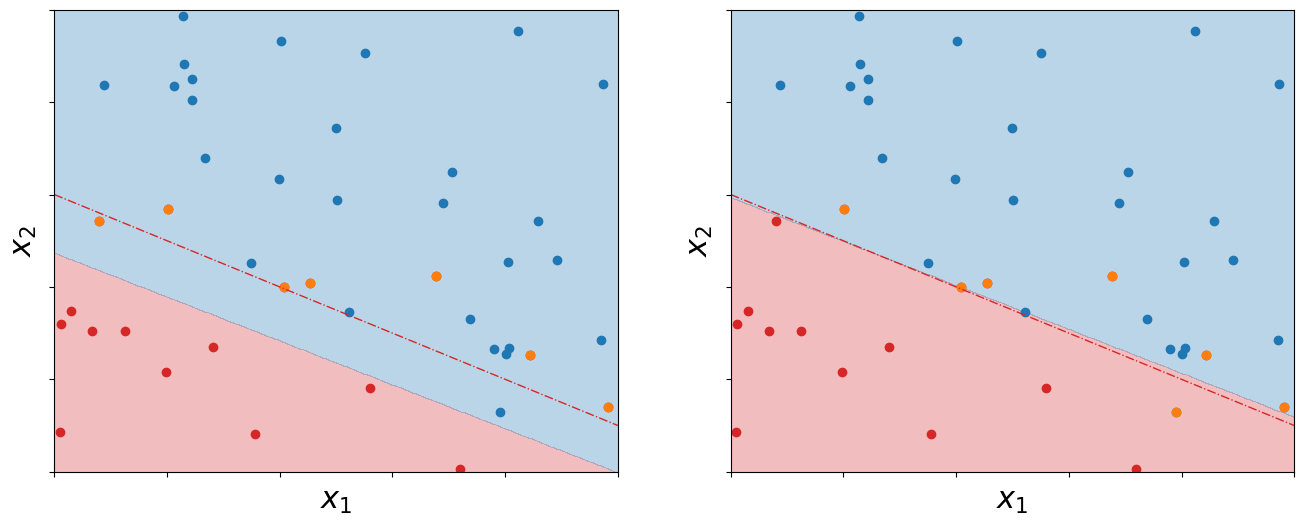

In [18]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )

prob_cut_list = [ 0.50, 0.75 ]

log_reg__ = log_reg_noise
df_test__ = df_test_noise

for idx_,prob_cut_ in enumerate( prob_cut_list ):
    n_points_ = 500
    data_x1_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
    data_x2_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
    grid_x1_, grid_x2_ = np.meshgrid( data_x1_, data_x2_ )
    datascan_ = np.c_[ grid_x1_.ravel(), grid_x2_.ravel() ]
    datascan_predict_ = ( ( log_reg__.predict_proba( datascan_ )[ :, 1] >= prob_cut_ ).reshape( grid_x1_.shape ) )

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap( ['tab:red','tab:blue'] )
    axes[ idx_ ].contourf( grid_x1_, grid_x2_, datascan_predict_, cmap=custom_cmap, alpha=0.30 )

    y_predict_test_ = np.full_like( df_test__[ "y_label" ], -1 )
    msk_ = ( df_test__[ "y_predict_proba" ] >= prob_cut_ )
    y_predict_test_[ msk_ ]  = +1
    y_predict_test_[ ~msk_ ] =  0

    msk_sig_ = ( df_test__[ "y_label" ] == +1 )
    msk_bkg_ = ( df_test__[ "y_label" ] ==  0 )
    msk_error_ = ( df_test__[ "y_label" ] != y_predict_test_ )
    df_test_sig_ = df_test__[ msk_sig_ ]
    df_test_bkg_ = df_test__[ msk_bkg_ ]
    df_test_error_ = df_test__[ msk_error_ ]
    axes[ idx_ ].plot( df_test_sig_[ "x1" ], df_test_sig_[ "x2" ], 'o', color='tab:blue' )
    axes[ idx_ ].plot( df_test_bkg_[ "x1" ], df_test_bkg_[ "x2" ], 'o', color='tab:red' )
    axes[ idx_ ].plot( df_test_error_[ "x1" ], df_test_error_[ "x2" ], 'o', color='tab:orange' )
    axes[ idx_ ].plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashdot', linewidth=1, color='tab:red' )

    axes[ idx_ ].set_xlim( x1_min, x1_max )
    axes[ idx_ ].set_ylim( x2_min, x2_max )
    axes[ idx_ ].set_xlabel( r'$x_1$' )
    axes[ idx_ ].set_ylabel( r'$x_2$' )
    axes[ idx_ ].xaxis.set_ticklabels( [] )
    axes[ idx_ ].yaxis.set_ticklabels( [] )

    accuracy = np.sum( df_test__[ "y_label" ] == y_predict_test_ ) / df_test__.shape[0]
    print ( "Accuracy = {}".format( accuracy ) )
